In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [3]:
data = pd.read_csv('D:/deep_data.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
None


In [5]:
print(data.nunique())

age                          47
anaemia                       2
creatinine_phosphokinase    208
diabetes                      2
ejection_fraction            17
high_blood_pressure           2
platelets                   176
serum_creatinine             40
serum_sodium                 27
sex                           2
smoking                       2
time                        148
DEATH_EVENT                   2
dtype: int64


In [6]:

''' 
    data 변수 분석
    anaemia 빈혈
    creatinine_phosphokinase 크레아티닌 인산화효소
    ejection_fraction 심장 피 분출률
    platelets 혈소판
    serum_creatinine 혈청 크레아티닌
    serum_sodium 혈청 나트륨
    time 환자 상태가 모니터된 시간(day)
'''



' \n    data 변수 분석\n    anaemia 빈혈\n    creatinine_phosphokinase 크레아티닌 인산화효소\n    ejection_fraction 심장 피 분출률\n    platelets 혈소판\n    serum_creatinine 혈청 크레아티닌\n    serum_sodium 혈청 나트륨\n    time 환자 상태가 모니터된 시간(day)\n'

<Axes: >

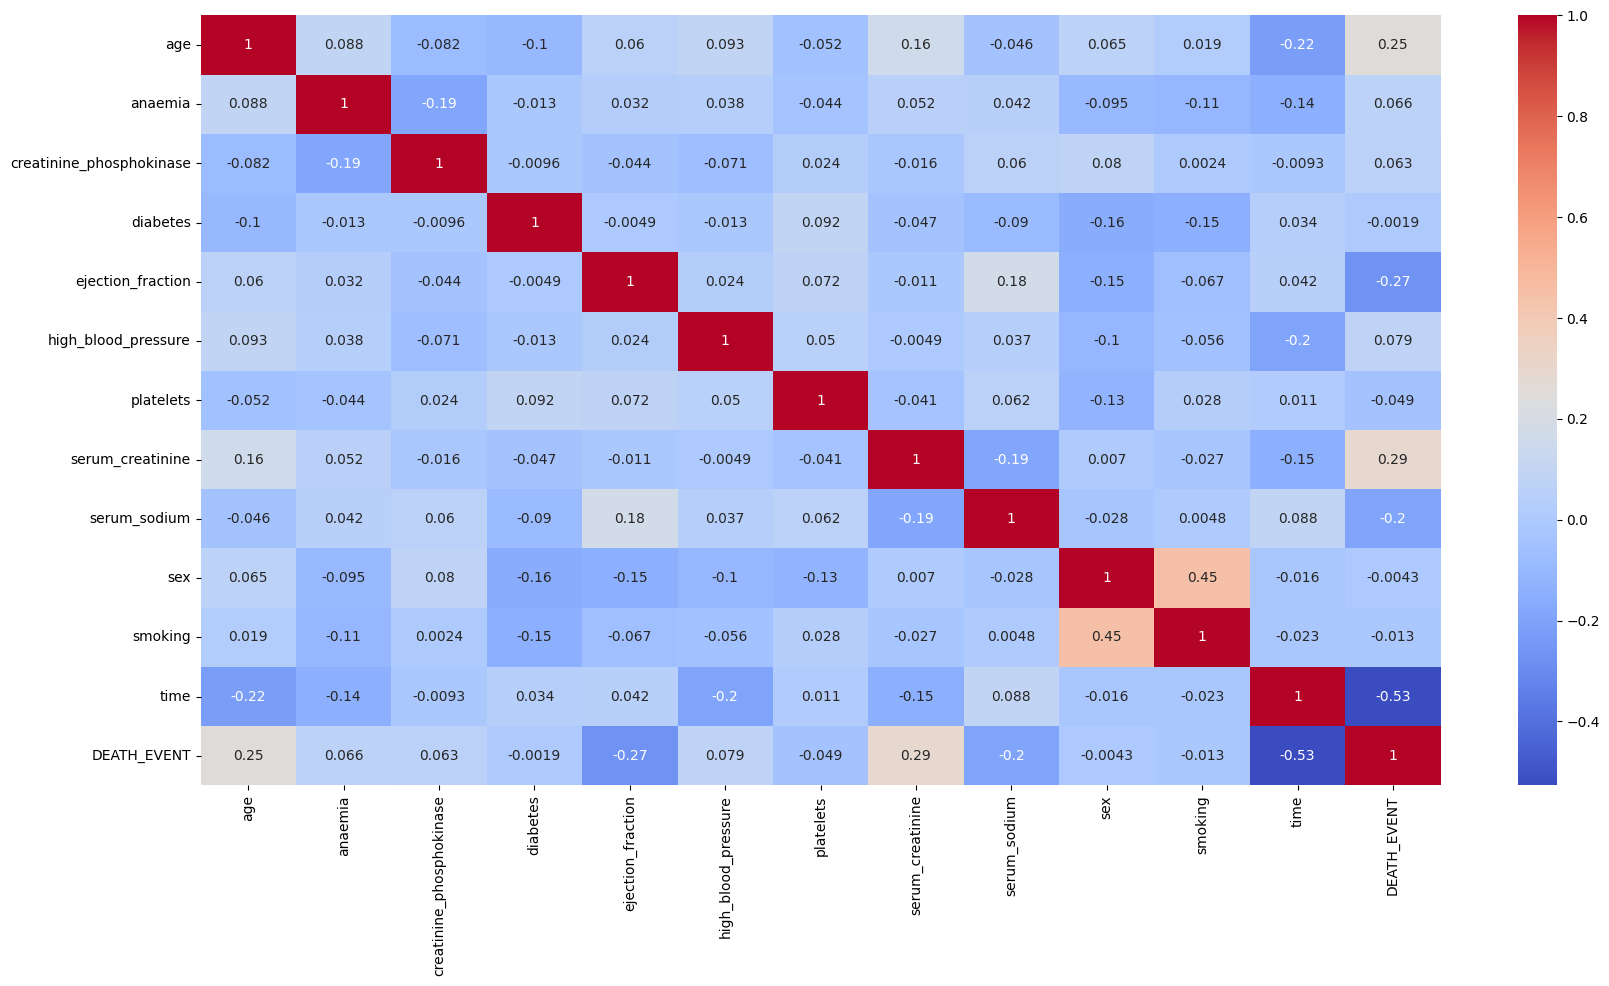

In [7]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot= True, cmap = 'coolwarm')

In [8]:
x_train = data.iloc[:, :-1].values
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
y_train = data.iloc[:, -1].values
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [9]:
class DNNModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential()
        model.add(Dense(15, input_shape=(self.input_shape,)))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(10))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(10))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def summary(self):
        print(self.model.summary())
    
    def compile(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    def train(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
        checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
        history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[checkpoint])
        return history
    
    def evaluate(self, x_test, y_test):
        best_model = load_model('best_model.keras')
        test_loss, test_acc = best_model.evaluate(x_test, y_test)
        print(f'Test accuracy: {test_acc}')
        return test_loss, test_acc
    
    def predict(self, x_data, model_path=None, threshold=0.5):
        best_model = load_model(model_path)
        predictions = best_model.predict(x_data)
        binary_predictions = (predictions > threshold).astype(int)
        return binary_predictions
'''        
# 모델 인스턴스 생성
model = DNNModel(input_shape=x_train.shape[1])
    
# 모델 컴파일
model.compile()
    
# 모델 학습
history = model.train(x_train, y_train, x_val, y_val, epochs=50, batch_size=10)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
max(history.history['val_accuracy'])
'''

"        \n# 모델 인스턴스 생성\nmodel = DNNModel(input_shape=x_train.shape[1])\n    \n# 모델 컴파일\nmodel.compile()\n    \n# 모델 학습\nhistory = model.train(x_train, y_train, x_val, y_val, epochs=50, batch_size=10)\n\nplt.plot(history.history['loss'], label='Train Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\n    \nplt.plot(history.history['accuracy'], label='Train Accuracy')\nplt.plot(history.history['val_accuracy'], label='Validation Accuracy')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\nmax(history.history['val_accuracy'])\n"

In [10]:
DNNModel(input_shape=x_train.shape[1]).summary()

d:\.conda\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\.conda\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476 (1.86 KB)

 Trainable params: 476 (1.86 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
DNN_model = DNNModel(input_shape=x_train.shape[1])
DNN_model.compile()
DNN_predictions = DNN_model.predict(x_val, model_path='best_model.keras')
DNN_predictions = pd.DataFrame(DNN_predictions, columns=['Prediction'])
DNN_predictions['real'] = y_val
DNN_val_accuracy = accuracy_score(DNN_predictions['real'], DNN_predictions['Prediction'])
DNN_precision = len(DNN_predictions[(DNN_predictions['Prediction'] == 0) & (DNN_predictions['real'] == 0)])/len(DNN_predictions[DNN_predictions['Prediction'] == 0])
print(f'val Accuracy: {DNN_val_accuracy}')
print('살았다는 예측에대한 정확도:',DNN_precision)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
val Accuracy: 0.85
살았다는 예측에대한 정확도: 0.8095238095238095


In [12]:
SVM_model = SVC(kernel='linear')
SVM_model.fit(x_train, y_train)
SVM_predictions = SVM_model.predict(x_val)
SVM_predictions = pd.DataFrame(SVM_predictions, columns=['Prediction'])
SVM_predictions['real'] = y_val
SVM_val_accuracy = accuracy_score(SVM_predictions['real'], SVM_predictions['Prediction'])
SVM_precision = len(SVM_predictions[(SVM_predictions['Prediction'] == 0) & (SVM_predictions['real'] == 0)])/len(SVM_predictions[SVM_predictions['Prediction'] == 0])
print(f'val Accuracy: {SVM_val_accuracy}')
print('살았다는 예측에대한 정확도:',SVM_precision)

val Accuracy: 0.75
살았다는 예측에대한 정확도: 0.7083333333333334


In [13]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
KNN_predictions = knn.predict(x_val)
KNN_predictions = pd.DataFrame(KNN_predictions, columns=['Prediction'])
KNN_predictions['real'] = y_val
KNN_val_accuracy = accuracy_score(KNN_predictions['real'], KNN_predictions['Prediction'])
KNN_precision = len(KNN_predictions[(KNN_predictions['Prediction'] == 0) & (KNN_predictions['real'] == 0)])/len(KNN_predictions[KNN_predictions['Prediction'] == 0])
print(f'val Accuracy: {KNN_val_accuracy}')
print('살았다는 예측에대한 정확도:',KNN_precision)

val Accuracy: 0.6833333333333333
살았다는 예측에대한 정확도: 0.6538461538461539


In [14]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
LOG_predictions = log_reg.predict(x_val)
LOG_predictions = pd.DataFrame(LOG_predictions, columns=['Prediction'])
LOG_predictions['real'] = y_val
LOG_val_accuracy = accuracy_score(LOG_predictions['real'], LOG_predictions['Prediction'])
LOG_precision = len(LOG_predictions[(LOG_predictions['Prediction'] == 0) & (LOG_predictions['real'] == 0)])/len(LOG_predictions[LOG_predictions['Prediction'] == 0])
print(f'val Accuracy: {LOG_val_accuracy}')
print('살았다는 예측에대한 정확도:',LOG_precision)

val Accuracy: 0.7166666666666667
살았다는 예측에대한 정확도: 0.68


In [15]:
random_forest = RandomForestClassifier(n_estimators=40, random_state=42)
random_forest.fit(x_train, y_train)
RF_predictions = random_forest.predict(x_val)
RF_predictions = pd.DataFrame(RF_predictions, columns=['Prediction'])
RF_predictions['real'] = y_val
RF_val_accuracy = accuracy_score(RF_predictions['real'], RF_predictions['Prediction'])
RF_precision = len(RF_predictions[(RF_predictions['Prediction'] == 0) & (RF_predictions['real'] == 0)])/len(RF_predictions[RF_predictions['Prediction'] == 0])
print(f'val Accuracy: {RF_val_accuracy}')
print('살았다는 예측에대한 정확도:',RF_precision)

val Accuracy: 0.75
살았다는 예측에대한 정확도: 0.7272727272727273


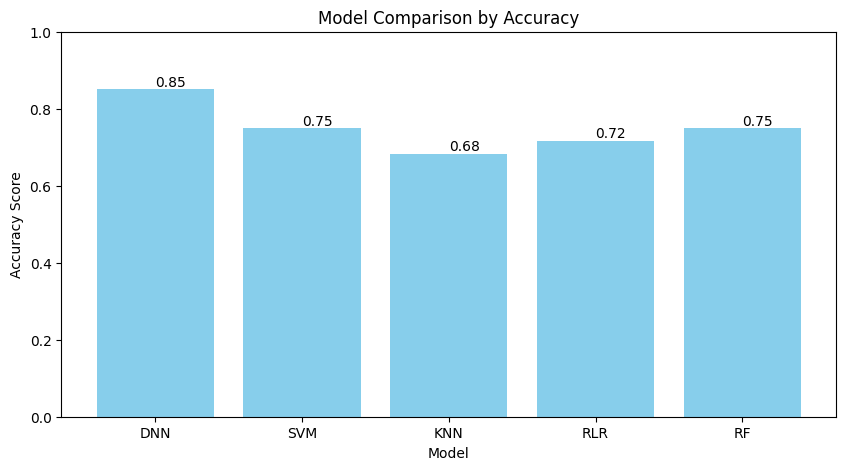

In [19]:
names = ['DNN','SVM','KNN','RLR','RF']
values = [DNN_val_accuracy, SVM_val_accuracy, KNN_val_accuracy, LOG_val_accuracy, RF_val_accuracy]

plt.figure(figsize=(10, 5))
bars = plt.bar(names, values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Model Comparison by Accuracy')
plt.ylim(0, 1)  # Adjust the limit to make room for text.

# Add text annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

plt.show()

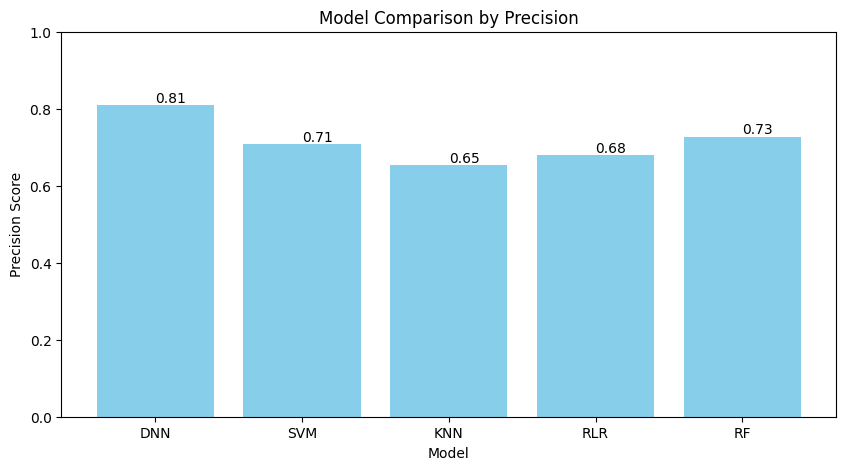

In [20]:
names = ['DNN','SVM','KNN','RLR','RF']
values = [DNN_precision, SVM_precision, KNN_precision, LOG_precision, RF_precision]

plt.figure(figsize=(10, 5))  # 그래프 크기 설정
bars = plt.bar(names, values, color='skyblue')  # 막대 그래프 그리기
plt.xlabel('Model')  # x축 레이블
plt.ylabel('Precision Score')  # y축 레이블
plt.title('Model Comparison by Precision')  # 그래프 제목
plt.ylim(0, 1)  # y축 범위 설정 (0부터 1까지 가정)
# Add text annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

plt.show()